In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
MLOST = xr.open_dataset('/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/SpatialPattern/SAT-OBS-Model/seasonalData/tas_MLOST_ano.nc')
MLOST_ano =MLOST.sel(time=slice('1892-01-01','1957-12-31'))

MLOST_ano


<xarray.Dataset>
Dimensions:  (time: 696, lon: 180, lat: 45)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 1957-12-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Data variables:
    air      (time, lat, lon) float32 ...

In [3]:
MLOST_ano['DJF'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='DJF').groupby('time.year').mean('time')
MLOST_ano['MAM'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='MAM').groupby('time.year').mean('time')
MLOST_ano['JJA'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='JJA').groupby('time.year').mean('time')
MLOST_ano['SON'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='SON').groupby('time.year').mean('time')

## Define function

In [4]:
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

## MLOST seasonal trend pattern

In [5]:
MLOST_ano['DJF_trend'], MLOST_ano['p_value_DJF'] = xr.apply_ufunc(calc_trend, MLOST_ano['DJF'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
MLOST_ano['MAM_trend'], MLOST_ano['p_value_MAM'] = xr.apply_ufunc(calc_trend, MLOST_ano['MAM'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
MLOST_ano['JJA_trend'], MLOST_ano['p_value_JJA'] = xr.apply_ufunc(calc_trend, MLOST_ano['JJA'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
MLOST_ano['SON_trend'], MLOST_ano['p_value_SON'] = xr.apply_ufunc(calc_trend, MLOST_ano['SON'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)

In [6]:
SAT_trend = xr.Dataset({
    'DJF': MLOST_ano['DJF_trend']*65.0,
    'MAM': MLOST_ano['MAM_trend']*65.0,
    'JJA': MLOST_ano['JJA_trend']*65.0,
    'SON': MLOST_ano['SON_trend']*65.0
}, coords={'longitude': MLOST_ano['lon'], 'latitude': MLOST_ano['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
SAT_trend

<xarray.Dataset>
Dimensions:    (lon: 180, lat: 45, season: 4)
Coordinates:
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    longitude  (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    latitude   (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    DJF        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MAM        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    JJA        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    SON        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [7]:
sig_ds = xr.Dataset({
    'DJF': MLOST_ano['p_value_DJF'],
    'MAM': MLOST_ano['p_value_MAM'],
    'JJA': MLOST_ano['p_value_JJA'],
    'SON': MLOST_ano['p_value_SON']
}, coords={'longitude': MLOST_ano['lon'], 'latitude': MLOST_ano['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
sig_ds

<xarray.Dataset>
Dimensions:    (lon: 180, lat: 45, season: 4)
Coordinates:
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    longitude  (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    latitude   (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    DJF        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MAM        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    JJA        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    SON        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

## MPI-ESM-Trend Calculating

In [8]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2022_*.nc'
ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [9]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [10]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)
masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 2076, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 2076, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [11]:
tas = masked_tas['tas'].loc[:,'1892-01-01':'1957-12-31',0:90,:]
tas = tas - 273.15
print(tas.min().values)
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_climatology
tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano_ds = tas_ano.to_dataset()
tas_ano_ds

-53.34633


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 66 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 792, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 1892-01-16T12:00:00 ... 1957-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [12]:
seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = tas_ano_ds.sel(time=tas.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies['tas']

# Access the multiyear JJA mean SAT anomalies
    
tas_ano_ds['JJA'] = season_means['JJA']
tas_ano_ds['DJF'] = season_means['DJF']
tas_ano_ds['MAM'] = season_means['MAM']
tas_ano_ds['SON'] = season_means['SON']

tas_ano_ds

<xarray.Dataset>
Dimensions:  (time: 792, lon: 180, lat: 45, run: 30, year: 66)
Coordinates:
  * time     (time) datetime64[ns] 1892-01-16T12:00:00 ... 1957-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 1892 1893 1894 1895 1896 ... 1953 1954 1955 1956 1957
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [13]:
import scipy.stats as stats
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

In [14]:
tas_ano_ds['slope_JJA'], tas_ano_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, tas_ano_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_JJA'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_JJA'].attrs['units'] = 'p_value'

In [15]:
tas_ano_ds['slope_DJF'], tas_ano_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, tas_ano_ds['DJF'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_DJF'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_DJF'].attrs['units'] = 'p_value'

In [16]:
tas_ano_ds['slope_MAM'], tas_ano_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, tas_ano_ds['MAM'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_MAM'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_MAM'].attrs['units'] = 'p_value'

In [17]:
tas_ano_ds['slope_SON'], tas_ano_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, tas_ano_ds['SON'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_SON'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_SON'].attrs['units'] = 'p_value'

In [18]:
tas_ano_ds = tas_ano_ds.compute()

In [19]:
tas_ano_ds

<xarray.Dataset>
Dimensions:      (time: 792, lon: 180, lat: 45, run: 30, year: 66)
Coordinates:
  * time         (time) datetime64[ns] 1892-01-16T12:00:00 ... 1957-12-16T12:...
  * lon          (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat          (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    height       (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * year         (year) int64 1892 1893 1894 1895 1896 ... 1954 1955 1956 1957
Dimensions without coordinates: run
Data variables: (12/13)
    tas          (run, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    JJA          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    DJF          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    MAM          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    SON          (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    slope_JJA    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    slope_DJF    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    p_value_DJF  (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    slope_MAM    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    p_value_MAM  (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    slope_SON    (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    p_value_SON  (run, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

## Selection of the minimum and maximum five models

In [20]:
model_65yr_MAM = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_1892_65yr_MAM_trend.txt',delimiter='\t', skip_header=1)
model_65yr_JJA = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_1892_65yr_JJA_trend.txt',delimiter='\t', skip_header=1)
model_65yr_SON = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_1892_65yr_SON_trend.txt',delimiter='\t', skip_header=1)
model_65yr_DJF = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_1892_65yr_DJF_trend.txt',delimiter='\t', skip_header=1)

DJF_65yr = xr.DataArray(model_65yr_DJF[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
MAM_65yr = xr.DataArray(model_65yr_MAM[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
SON_65yr = xr.DataArray(model_65yr_SON[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
JJA_65yr = xr.DataArray(model_65yr_JJA[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})

# assume you have an xarray called 'xr_data'
# get the most minimum five values and their indices
min_indices = np.argpartition(DJF_65yr.values.flatten(), 5)[:5]
min_values = DJF_65yr.values.flatten()[min_indices]
min_coords = np.unravel_index(min_indices, DJF_65yr.shape)

# create a new xarray to store the most minimum values
min_xr = xr.DataArray(min_values, dims=['value'], coords={'value': np.arange(5)})

# print the new xarray
print(min_xr)
print(min_coords)

<xarray.DataArray (value: 5)>
array([ 0.4067654 ,  0.30901197, -0.04416605,  0.28459771,  0.30231661])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([26, 13, 11,  9, 10]),)


In [21]:
max_indices = np.argpartition(DJF_65yr.values.flatten(), -5)[-5:]
max_values = DJF_65yr.values.flatten()[max_indices]
max_coords = np.unravel_index(max_indices, DJF_65yr.shape)

max_xr = xr.DataArray(max_values, dims=['value'], coords={'value': np.arange(5)})
print(max_xr)
print(max_coords)
type(max_coords)
max_coords

<xarray.DataArray (value: 5)>
array([0.89360416, 0.95020756, 1.16891194, 1.0589495 , 1.12011435])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([19, 14,  5, 18,  6]),)


(array([19, 14,  5, 18,  6]),)

In [22]:
max_JJA_indices = np.argpartition(JJA_65yr.values.flatten(), -5)[-5:]
max_JJA_values = JJA_65yr.values.flatten()[max_JJA_indices]
max_JJA_coords = np.unravel_index(max_JJA_indices, JJA_65yr.shape)

max_JJA_xr = xr.DataArray(max_JJA_values, dims=['value'], coords={'value': np.arange(5)})
print(max_JJA_xr)
print(max_JJA_coords)
type(max_JJA_coords)
max_JJA_coords

<xarray.DataArray (value: 5)>
array([0.6023391 , 0.60316094, 0.79722699, 0.67094744, 0.72764335])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([23, 14,  5, 18, 10]),)


(array([23, 14,  5, 18, 10]),)

In [23]:
min_JJA_indices = np.argpartition(JJA_65yr.values.flatten(), 5)[:5]
min_JJA_values = JJA_65yr.values.flatten()[min_JJA_indices]
min_JJA_coords = np.unravel_index(min_JJA_indices, JJA_65yr.shape)

min_JJA_xr = xr.DataArray(min_JJA_values, dims=['value'], coords={'value': np.arange(5)})
print(min_JJA_xr)
print(min_JJA_coords)
type(min_JJA_coords)
min_JJA_coords

<xarray.DataArray (value: 5)>
array([0.31936375, 0.2398206 , 0.35839467, 0.37383327, 0.37842837])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([22, 26, 12, 13,  1]),)


(array([22, 26, 12, 13,  1]),)

In [24]:
max_MAM_indices = np.argpartition(MAM_65yr.values.flatten(), -5)[-5:]
max_MAM_values = MAM_65yr.values.flatten()[max_MAM_indices]
max_MAM_coords = np.unravel_index(max_MAM_indices, MAM_65yr.shape)

max_MAM_xr = xr.DataArray(max_MAM_values, dims=['value'], coords={'value': np.arange(5)})
print(max_MAM_xr)
print(max_MAM_coords)
type(max_MAM_coords)
max_MAM_coords

<xarray.DataArray (value: 5)>
array([0.77330356, 0.78196457, 0.79428202, 0.85134786, 0.82234399])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([ 3,  2, 18,  5,  0]),)


(array([ 3,  2, 18,  5,  0]),)

In [25]:
min_MAM_indices = np.argpartition(MAM_65yr.values.flatten(), 5)[:5]
min_MAM_values = MAM_65yr.values.flatten()[min_MAM_indices]
min_MAM_coords = np.unravel_index(min_MAM_indices, MAM_65yr.shape)

min_MAM_xr = xr.DataArray(min_MAM_values, dims=['value'], coords={'value': np.arange(5)})
print(min_MAM_xr)
print(min_MAM_coords)
type(min_MAM_coords)
min_MAM_coords

<xarray.DataArray (value: 5)>
array([0.06516459, 0.17851797, 0.23385392, 0.27963128, 0.28004365])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([11, 26, 13, 22, 12]),)


(array([11, 26, 13, 22, 12]),)

In [26]:
max_SON_indices = np.argpartition(SON_65yr.values.flatten(), -5)[-5:]
max_SON_values = SON_65yr.values.flatten()[max_SON_indices]
max_SON_coords = np.unravel_index(max_SON_indices, SON_65yr.shape)

max_SON_xr = xr.DataArray(max_SON_values, dims=['value'], coords={'value': np.arange(5)})
print(max_SON_xr)
print(max_SON_coords)
type(max_SON_coords)
max_SON_coords

<xarray.DataArray (value: 5)>
array([0.72181054, 0.72835067, 0.72327799, 0.95382553, 0.82263381])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([ 0, 15, 27,  3, 23]),)


(array([ 0, 15, 27,  3, 23]),)

In [27]:
min_SON_indices = np.argpartition(SON_65yr.values.flatten(), 5)[:5]
min_SON_values = SON_65yr.values.flatten()[min_SON_indices]
min_SON_coords = np.unravel_index(min_SON_indices, SON_65yr.shape)

min_SON_xr = xr.DataArray(min_SON_values, dims=['value'], coords={'value': np.arange(5)})
print(min_SON_xr)
print(min_SON_coords)
type(min_SON_coords)
min_SON_coords

<xarray.DataArray (value: 5)>
array([0.27325817, 0.11860868, 0.25411982, 0.33250129, 0.35874808])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([21, 11, 26, 13, 20]),)


(array([21, 11, 26, 13, 20]),)

## Plot the trend pattern of the DJF 65-yr Spatial pattern

In [28]:
slope_JJA = tas_ano_ds['slope_JJA'] 
slope_DJF = tas_ano_ds['slope_DJF']
slope_MAM = tas_ano_ds['slope_MAM']
slope_SON = tas_ano_ds['slope_SON']

p_value_JJA = tas_ano_ds['p_value_JJA']
p_value_DJF = tas_ano_ds['p_value_DJF']
p_value_MAM = tas_ano_ds['p_value_MAM']
p_value_SON = tas_ano_ds['p_value_SON']

In [29]:
slope_JJA_data = slope_JJA*65.0
slope_DJF_data = slope_DJF*65.0
slope_MAM_data = slope_MAM*65.0
slope_SON_data = slope_SON*65.0

In [30]:
slope_DJF_data

<xarray.DataArray 'slope_DJF' (run: 30, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Dimensions without coordinates: run

In [31]:
slope_JJA_MME = slope_JJA_data.mean(dim='run')
slope_DJF_MME = slope_DJF_data.mean(dim='run')
slope_MAM_MME = slope_MAM_data.mean(dim='run')
slope_SON_MME = slope_SON_data.mean(dim='run')

In [32]:
#using the for loop to pick up the min5 and max5 data of DJF 


# Extract trend spatial data for minimum five runs in DJF
DJF_min5_trend = []
for i in range(5):
    run_index = min_coords[0][i]
    DJF_min5_trend.append(slope_DJF_data[run_index,:,:])
DJF_min5_trend = xr.concat(DJF_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in DJF
DJF_max5_trend = []
for i in range(5):
    run_index = max_coords[0][i]
    DJF_max5_trend.append(slope_DJF_data[run_index,:,:])
DJF_max5_trend = xr.concat(DJF_max5_trend, dim='run')

# Extract trend spatial data for minimum five runs in JJA
JJA_min5_trend = []
for i in range(5):
    run_index = min_JJA_coords[0][i]
    JJA_min5_trend.append(slope_JJA_data[run_index,:,:])
JJA_min5_trend = xr.concat(JJA_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in JJA
JJA_max5_trend = []
for i in range(5):
    run_index = max_JJA_coords[0][i]
    JJA_max5_trend.append(slope_JJA_data[run_index,:,:])
JJA_max5_trend = xr.concat(JJA_max5_trend, dim='run')

# Extract trend spatial data for minimum five runs in MAM
MAM_min5_trend = []
for i in range(5):
    run_index = min_MAM_coords[0][i]
    MAM_min5_trend.append(slope_MAM_data[run_index,:,:])
MAM_min5_trend = xr.concat(MAM_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in MAM
MAM_max5_trend = []
for i in range(5):
    run_index = max_MAM_coords[0][i]
    MAM_max5_trend.append(slope_MAM_data[run_index,:,:])
MAM_max5_trend = xr.concat(MAM_max5_trend, dim='run')

# Extract trend spatial data for minimum five runs in SON
SON_min5_trend = []
for i in range(5):
    run_index = min_SON_coords[0][i]
    SON_min5_trend.append(slope_SON_data[run_index,:,:])
SON_min5_trend = xr.concat(SON_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in SON
SON_max5_trend = []
for i in range(5):
    run_index = max_SON_coords[0][i]
    SON_max5_trend.append(slope_SON_data[run_index,:,:])
SON_max5_trend = xr.concat(SON_max5_trend, dim='run')


In [33]:
JJA_max5_trend

<xarray.DataArray 'slope_JJA' (run: 5, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Dimensions without coordinates: run

In [34]:
# Calculate the DJF min 5 trend mean
DJF_min5_trend_mean = DJF_min5_trend.mean(dim='run')
DJF_max5_trend_mean = DJF_max5_trend.mean(dim='run')

# Calculate the JJA min 5 trend mean
JJA_min5_trend_mean = JJA_min5_trend.mean(dim='run')
JJA_max5_trend_mean = JJA_max5_trend.mean(dim='run')

# Calculate the MAM min 5 trend mean
MAM_min5_trend_mean = MAM_min5_trend.mean(dim='run')
MAM_max5_trend_mean = MAM_max5_trend.mean(dim='run')

# Calculate the SON min 5 trend mean
SON_min5_trend_mean = SON_min5_trend.mean(dim='run')
SON_max5_trend_mean = SON_max5_trend.mean(dim='run')

In [35]:
# put the trend data into a dataset for plotting
trend_data = {
        'DJF':{
                'OBS': SAT_trend['DJF'][::-1,:],
                'MME': slope_DJF_MME[::-1,:],
                'min5': DJF_min5_trend_mean[::-1,:],
                'max5': DJF_max5_trend_mean[::-1,:]
        },
        'JJA':{
                'OBS': SAT_trend['JJA'][::-1,:],
                'MME': slope_JJA_MME[::-1,:],
                'min5': JJA_min5_trend_mean[::-1,:],
                'max5': JJA_max5_trend_mean[::-1,:]
        },
        'MAM':{
                'OBS': SAT_trend['MAM'][::-1,:],
                'MME': slope_MAM_MME[::-1,:],
                'min5': MAM_min5_trend_mean[::-1,:],
                'max5': MAM_max5_trend_mean[::-1,:]
        },
        'SON':{
                'OBS': SAT_trend['SON'][::-1,:],
                'MME': slope_SON_MME[::-1,:],
                'min5': SON_min5_trend_mean[::-1,:],
                'max5': SON_max5_trend_mean[::-1,:]
        },

}

## Draw the member's spatial pattern

/tmp/ipykernel_2440969/2335078848.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0.35, 1, 0.95])  # Adjust the layout to accommodate the suptitle and colorbar
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


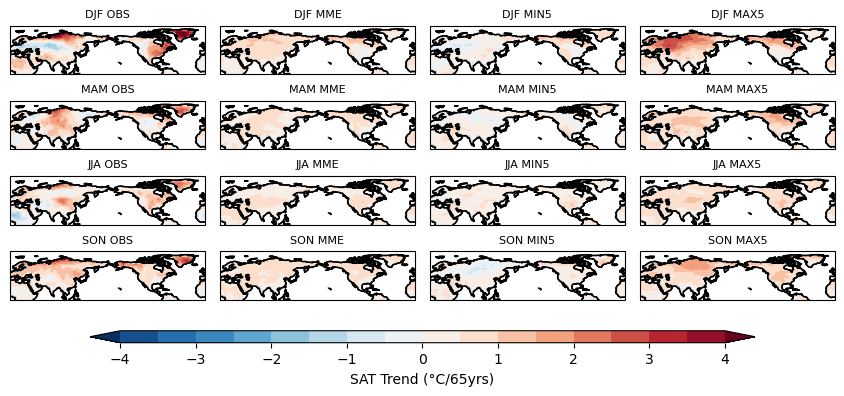

In [36]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap

# Update the plot_trend_data function to take the axis as an argument
def plot_trend_data(trend_data, ax, title):
    cmap = mpl.cm.RdBu_r
    bounds = [-4.0, -3.5, -3.0, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5, 4.0]
    # bounds = [-3.0, -2.75, -2.5, -2.25, -2, -1.75, -1.5,-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3.0]

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    ax.coastlines()
    ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())  # Set the Northern Hemisphere extent
    ax.set_xticks([])
    ax.set_yticks([])
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    im = ax.imshow(trend_data, extent=[-180, 180, 0, 90], transform=ccrs.PlateCarree(central_longitude=180), cmap=cmap, norm=norm)
    ax.set_title(title,fontname='Times New Roman',fontsize=8)
    # Adding the title as text in the bottom-right corner
    return im

#Creat a function to plot the trend data
fig, axs = plt.subplots(4, 4, figsize=(9.5, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# loop over the subplots and plot the data
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    for j, member in enumerate(['OBS', 'MME', 'min5', 'max5']):
        im = plot_trend_data(trend_data[season][member], axs[i, j], f'{season} {member.upper()}')

# add a common colorbar for all subplots
cax = fig.add_axes([0.2, 0.35, 0.7, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('SAT Trend (°C/65yrs)', fontname='Times New Roman',fontsize=10)

# plt.subplots_adjust(hspace=0.1)  # Adjust the spacing between subplots
plt.tight_layout(rect=[0.1, 0.35, 1, 0.95])  # Adjust the layout to accommodate the suptitle and colorbar
plt.savefig('1892-1957_SAT_Trend_Patterns.png', bbox_inches='tight', dpi=300)

plt.show()